In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import linear_model
import string
import json
import matplotlib.pyplot as plt

In [2]:
products = pd.read_csv(r"D:\Classification\Project 8\data\amazon_baby.csv")

In [3]:
products.head()

,name,review,rating
0,Planetwise Flannel Wipes,"These flannel wipes are OK, but in my opinion ...",3
1,Planetwise Wipe Pouch,it came early and was not disappointed. i love...,5
2,Annas Dream Full Quilt with 2 Shams,Very soft and comfortable and warmer than it l...,5
3,Stop Pacifier Sucking without tears with Thumb...,This is a product well worth the purchase. I ...,5
4,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5


#### Perform text cleaning

In [4]:
products = products.fillna({'review':''})  # fill in N/A's in the review column

In [5]:
trans_table=str.maketrans('','',string.punctuation)
products['review_clean']=products['review'].apply(lambda text: text.translate(trans_table))
#removing punctuation from the reviews

#### Extract Sentiments

In [6]:
products = products[products['rating'] != 3]

In [7]:
products['sentiment'] = products['rating'].apply(lambda rating : +1 if rating > 3 else -1)

In [8]:
with open(r"D:\Classification\Project 8\data\train-idx.json") as f:
    train_idx=json.load(f)
with open(r"D:\Classification\Project 8\data\test-idx.json") as f:
    test_idx=json.load(f)

In [9]:
train_data=products.iloc[train_idx]
test_data=products.iloc[test_idx]

#### Build the word count vector for each review

In [10]:
vectorizer = CountVectorizer(token_pattern=r'\b\w+\b')
train_matrix = vectorizer.fit_transform(train_data['review_clean'])
# Second, convert the test data into a sparse matrix, using the same word-column mapping
test_matrix = vectorizer.transform(test_data['review_clean'])

#### Train a sentiment classifier with logistic regression

In [11]:
model=linear_model.LogisticRegression()

In [12]:
model.fit(train_matrix, train_data['sentiment'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

#### Accuracy
$$
\mbox{accuracy} = \dfrac{\mbox{# correctly classified data points}}{\mbox{# total data points}}
$$

In [13]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_true=test_data['sentiment'], y_pred=model.predict(test_matrix))
print("Test Accuracy: %s" % accuracy)

Test Accuracy: 0.9321154307655387


#### Baseline: Majority class prediction

In [14]:
len(test_data[test_data['sentiment'] == 1]),len(test_data[test_data['sentiment'] == -1])

(28095, 5241)

In [15]:
baseline = len(test_data[test_data['sentiment'] == 1])/len(test_data)
print("Baseline accuracy (majority class classifier): %s" % baseline)

Baseline accuracy (majority class classifier): 0.8427825773938085


#### Confusion Matrix

In [16]:
from sklearn.metrics import confusion_matrix
cmat = confusion_matrix(y_true=test_data['sentiment'],
                        y_pred=model.predict(test_matrix),
                        labels=model.classes_)    # use the same order of class as the LR model.
print(' target_label | predicted_label | count ')
print('--------------+-----------------+-------')
for i, target_label in enumerate(model.classes_):
    for j, predicted_label in enumerate(model.classes_):
        print('{0:^13} | {1:^15} | {2:5d}'.format(target_label, predicted_label, cmat[i,j]))

 target_label | predicted_label | count 
--------------+-----------------+-------
     -1       |       -1        |  3786
     -1       |        1        |  1455
      1       |       -1        |   808
      1       |        1        | 27287


#### Computing the cost of mistakes
\$100 for each false positive.

\$1 for each false negative.

Correctly classified reviews incur no cost.

In [17]:
cost=(100*1455)+808
cost

146308

#### Precision and Recall
$$
[\mbox{precision}] = \dfrac{[\mbox{# positive data points with positive predictions}]}{[\mbox{# all data points with positive predictions}]} = \dfrac{[\mbox{# true positives}]}{[\mbox{# true positives}] + [\mbox{# false positives}]}
$$

In [18]:
from sklearn.metrics import precision_score
precision = precision_score(y_true=test_data['sentiment'], 
                            y_pred=model.predict(test_matrix))
print("Precision on test data: %s" % precision)

Precision on test data: 0.9493772180084893


In [19]:
print("Out of all reviews in the test set that are predicted to be positive, %s fraction of them are false positives"
      % (1-precision))

Out of all reviews in the test set that are predicted to be positive, 0.05062278199151071 fraction of them are false positives


If we wanted to reduce this fraction of false positives to be below 3.5%, we should increase threshold for predicting the positive class. 

$$
[\text{recall}] = \dfrac{[\text{# positive data points with positive predicitions}]}{\text{[# all positive data points]}} = \dfrac{[\text{# true positives}]}{[\text{# true positives}] + [\text{# false negatives}]}
$$

In [20]:
from sklearn.metrics import recall_score
recall = recall_score(y_true=test_data['sentiment'],
                      y_pred=model.predict(test_matrix))
print("Recall on test data: %s" % recall)

Recall on test data: 0.9712404342409682


#### Precision-recall tradeoff

False positives are costly in our case, so we may want to be more conservative about making positive predictions. To achieve this, instead of thresholding class probabilities at 0.5, we can choose a higher threshold.

In [21]:
def apply_threshold(probabilities, threshold):
    prediction = pd.Series(probabilities).apply(lambda probability: +1 if probability > threshold else -1)
    return prediction

In [22]:
probabilities = model.predict_proba(test_matrix)[:,1]

In [23]:
prediction_1 = apply_threshold(probabilities, 0.5)

In [24]:
prediction_2 = apply_threshold(probabilities, 0.9)

In [25]:
sum(prediction_1 == 1)

28742

In [26]:
sum(prediction_2 == 1)

25076

The number of positive predicted reviews decreases as the threshold increased from 0.5 to 0.9.

#### Exploring the associated precision and recall as the threshold varies

In [27]:
precision_1 = precision_score(y_true=test_data['sentiment'], 
                            y_pred=prediction_1)
precision_2 = precision_score(y_true = test_data['sentiment'],
                             y_pred = prediction_2)

In [28]:
recall_1 = recall_score(y_true=test_data['sentiment'],
                       y_pred=prediction_1)
recall_2 = recall_score(y_true=test_data['sentiment'],
                       y_pred=prediction_2)

In [29]:
precision_1,precision_2

(0.9493772180084893, 0.9814563726272133)

In [30]:
recall_1,recall_2

(0.9712404342409682, 0.8759921694251647)

Precision increases and recall decreases as the threshold increased from 0.5 to 0.9.

#### Precision-recall curve

In [31]:
threshold_values = np.linspace(0.5, 1, num=100)
print(threshold_values)

[0.5        0.50505051 0.51010101 0.51515152 0.52020202 0.52525253
 0.53030303 0.53535354 0.54040404 0.54545455 0.55050505 0.55555556
 0.56060606 0.56565657 0.57070707 0.57575758 0.58080808 0.58585859
 0.59090909 0.5959596  0.6010101  0.60606061 0.61111111 0.61616162
 0.62121212 0.62626263 0.63131313 0.63636364 0.64141414 0.64646465
 0.65151515 0.65656566 0.66161616 0.66666667 0.67171717 0.67676768
 0.68181818 0.68686869 0.69191919 0.6969697  0.7020202  0.70707071
 0.71212121 0.71717172 0.72222222 0.72727273 0.73232323 0.73737374
 0.74242424 0.74747475 0.75252525 0.75757576 0.76262626 0.76767677
 0.77272727 0.77777778 0.78282828 0.78787879 0.79292929 0.7979798
 0.8030303  0.80808081 0.81313131 0.81818182 0.82323232 0.82828283
 0.83333333 0.83838384 0.84343434 0.84848485 0.85353535 0.85858586
 0.86363636 0.86868687 0.87373737 0.87878788 0.88383838 0.88888889
 0.89393939 0.8989899  0.9040404  0.90909091 0.91414141 0.91919192
 0.92424242 0.92929293 0.93434343 0.93939394 0.94444444 0.94949

In [32]:
precision_all = [precision_score(y_true=test_data['sentiment'], y_pred=apply_threshold(probabilities, threshold))
                 for threshold in threshold_values ]

recall_all = [recall_score(y_true=test_data['sentiment'], y_pred=apply_threshold(probabilities, threshold))
                 for threshold in threshold_values]

C:\Users\Govind\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [33]:
def plot_pr_curve(precision, recall, title):
    plt.rcParams['figure.figsize'] = 7, 5
    plt.locator_params(axis = 'x', nbins = 5)
    plt.plot(precision, recall, 'b-', linewidth=4.0, color = '#B0017F')
    plt.title(title)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.rcParams.update({'font.size': 16})

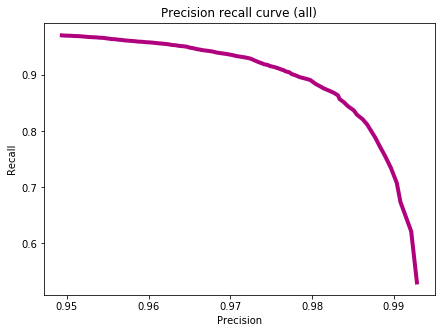

In [34]:
plot_pr_curve(precision_all[0:99], recall_all[0:99], 'Precision recall curve (all)')

In [35]:
precision_all[99],recall_all[99]

(0.0, 0.0)

In [36]:
print("Among all the threshold values tried, %s is the smallest threshold value that \
achieves a precision of 96.5%% or better." % min([thrsh for thrsh,prec in zip(threshold_values,precision_all) if prec>=0.965]))

Among all the threshold values tried, 0.7070707070707071 is the smallest threshold value that achieves a precision of 96.5% or better.


In [37]:
cmat = confusion_matrix(y_true=test_data['sentiment'],
                        y_pred=apply_threshold(probabilities, 0.98),
                        labels=model.classes_)    # use the same order of class as the LR model.
print(' target_label | predicted_label | count ')
print('--------------+-----------------+-------')
for i, target_label in enumerate(model.classes_):
    for j, predicted_label in enumerate(model.classes_):
        print('{0:^13} | {1:^15} | {2:5d}'.format(target_label, predicted_label, cmat[i,j]))

 target_label | predicted_label | count 
--------------+-----------------+-------
     -1       |       -1        |  5047
     -1       |        1        |   194
      1       |       -1        |  8230
      1       |        1        | 19865


In [38]:
print("Using threshold = 0.98, 8230 false negatives we get on the test_data.")

Using threshold = 0.98, 8230 false negatives we get on the test_data.


#### Evaluating specific search terms

So far, we looked at the number of false positives for the entire test set. Let's select reviews using a specific search term and optimize the precision on these reviews only. After all, a manufacturer would be interested in tuning the false positive rate just for their products (the reviews they want to read) rather than that of the entire set of products on Amazon.

#### Precision-Recall on all baby related items

In [39]:
test_data['name'] = test_data['name'].astype('str')

C:\Users\Govind\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [40]:
baby_reviews = test_data[test_data['name'].apply(lambda x: 'baby' in x.lower())]

In [41]:
baby_matrix = vectorizer.transform(baby_reviews['review_clean'])
probabilities = model.predict_proba(baby_matrix)[:,1]

In [42]:
threshold_values = np.linspace(0.5, 1, num=100)

In [43]:
precision_all = [precision_score(y_true=baby_reviews['sentiment'], y_pred=apply_threshold(probabilities, threshold))
                 for threshold in threshold_values ]

recall_all = [recall_score(y_true=baby_reviews['sentiment'], y_pred=apply_threshold(probabilities, threshold))
                 for threshold in threshold_values]

C:\Users\Govind\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


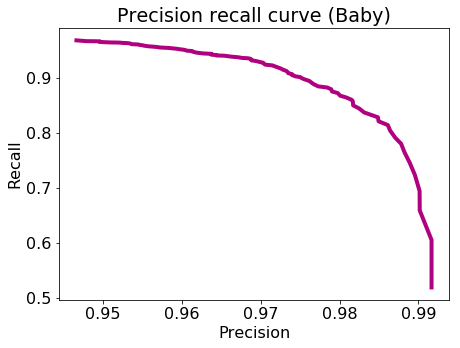

In [44]:
plot_pr_curve(precision_all[0:99], recall_all[0:99], 'Precision recall curve (Baby)')

In [45]:
print("Among all the threshold values tried, %s is the smallest threshold value that \
achieves a precision of 96.5%% or better." % min([thrsh for thrsh,prec in zip(threshold_values,precision_all) if prec>=0.965]))

Among all the threshold values tried, 0.7323232323232324 is the smallest threshold value that achieves a precision of 96.5% or better.


This threshold value is larger than the threshold used for the entire dataset to achieve the same specified precision of 96.5%